<a href="https://colab.research.google.com/github/yexf308/MAT592/blob/main/9_SVM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is partially from https://jonchar.net/notebooks/SVM/.

# Support Vector Machines 
### Perception revisited: linear separators 

perceptron is the composition of linear model and binary step function: (IN SVM section, we move the interception out and usually the class label is $\pm 1$)

$$\phi(\mathbf{w}^\top\mathbf{x}+w_0)=\begin{cases} 1 (\text{class 1})& \text{if }  \mathbf{w}^\top\mathbf{x}+w_0>0 \\   -1(\text{class -1}) & \text{otherwise}\end{cases} $$

This is a linear separator and only the sign of $\mathbf{w}^\top\mathbf{x}+w_0$ matters in making prediction. So the hyperplane $\mathbf{w}^\top\mathbf{x}+w_0=0$ is the **decision boundary**.

Given linearly separable data, the perceptron algorithm may converge to any of
the following solutions. These are all solutions to the optimization problem because at the global minimum 0, training data points only need to be on the
correct side of separating line. 




In [22]:
%pylab inline 
from IPython.display import Image

Image(url='https://github.com/yexf308/MAT592/blob/main/image/dec_bound.png?raw=true', width=600)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## What is the best separator?
Most stable under perturbations of the inputs.

In [23]:
Image(url='https://github.com/yexf308/MAT592/blob/main/image/best_sep.png?raw=true', width=1000)

### Mathematical formulation of Hard Margin Classification

When we apply a threshold that gives us the largest margin (meaning that we are strict to ensure that no instances land within the margin) to make classifications this is called **Hard Margin Classification**. 

- Suppose the data points are separable by linear functions.
- Unit-length vector of the hyper-plane $\mathbf{w}^\top\mathbf{x}+w_0=0$ is $\mathbf{n}= \frac{\mathbf{w}}{\|\mathbf{w}\|}$. (plot it)

- since $\mathbf{w}^\top\mathbf{x}+w_0=0$ and $c(\mathbf{w}^\top\mathbf{x}+w_0)=0$ define the same plane, we will have the freedom to choose the norm of $\mathbf{w}$.   

-  Samples closest to the decision hyperplane are called **support vectors**. Without loss of generality, simply assume support vectors lie on hyperplanes $\mathbf{w}^\top\mathbf{x}+w_0=\pm 1$, called **margin boundary** 

In [24]:
Image(url='https://github.com/yexf308/MAT592/blob/main/image/svm.png?raw=true', width=600)

- Any sample $\mathbf{x}^{(i)}$ other than support vectors obeys $\mathbf{w}^\top\mathbf{x}+w_0>1$ or $\mathbf{w}^\top\mathbf{x}+w_0<-1$.

- Distance from any point $\mathbf{x}$ to the hyperplane separator $\mathbf{w}^\top\mathbf{x}+w_0=0$ is 
$$ r= \frac{|\mathbf{w}^\top\mathbf{x}+w_0|}{\|\mathbf{w}\|}$$

- Distance from support vectors to separator is defined as the margin $\rho=\frac{2}{\|\mathbf{w}\|}$. We want to maximize the margin. 

In [25]:
Image(url='https://github.com/yexf308/MAT592/blob/main/image/margin.png?raw=true', width=600)

Given linearly separable training set $\{\mathbf{x}^{(i)}, y^{(i)}\}\subset \mathbb{R}^d\times\{\pm 1\}$,
- **constraints**: for $\{\mathbf{x}^{(i)}, y^{(i)}\}$,  label is set so that $y^{(i)} = 1$ if $\mathbf{w}^\top \mathbf{x}^{(i)} +w_0 \geq 1$, and $\mathbf{y}^{(i)} = -1$ if $\mathbf{w}^\top \mathbf{x} +w_0 \leq -1$. Uniformly,
$$
\mathbf{y}^{(i)}  (\mathbf{w}^\top \mathbf{x}^{(i)} +w_0 )\geq 1, \; \forall \, i
$$

- find the max margin solution: 
$$\max_{\mathbf{w}, w_0} \rho:= \frac{2}{\|\mathbf{w}\|} \text{, subject to } \mathbf{y}^{(i)}  (\mathbf{w}^\top \mathbf{x}^{(i)} +w_0 )\geq 1, \; \forall \, i
$$

or equivalently, 
$$\min_{\mathbf{w}, w_0} \frac{1}{2}\|\mathbf{w}\|_2^2 \text{, subject to } \mathbf{y}^{(i)}  (\mathbf{w}^\top \mathbf{x}^{(i)} +w_0 )\geq 1, \; \forall \, i
$$

- It is quadratic programming: quadratic objective subject to linear constraints. It is a convex problem and there is unique global minimum. 

- This formulation can be solved using existing quadratic programming solvers such as CVXOPT and other methods. However, there is another formulation of the problem that can be solved without using quadratic programming techniques. 

- prediction: with the optimal parameters $(\mathbf{w}^*, w_0^*)$, one predicts $y= \text{sign}(\mathbf{w}^{*\top} \mathbf{x} +w_0^*)$



## Warning: Optimization!!!
Whiteboard derivation. 


We will instead implement a version of the Sequential Minimal Optimization (SMO) algorithm as described by John Platt to solve our optimization problem. This is much more involved. Try to follow it if you can.



In [26]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler


In [27]:
#some toy data generated by scikit-learn's
X_train, y = make_blobs(n_samples=500, centers=2,
                        n_features=2, random_state=1)
# We'll also scale the data to be centered at the origin with a unit standard deviation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
# we have to change the class labels to be +1 and -1 instead of 0 and 1.
y[y == 0] = -1

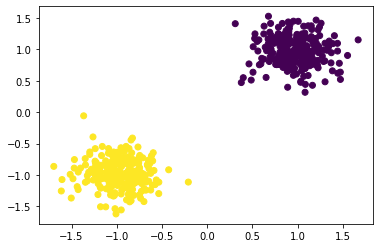

In [28]:
scatter(X_train_scaled[:,0],X_train_scaled[:,1],c=y)

In [29]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function, here we only use linear kernel
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set


In [30]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""
    
    return x @ y.T + b # Note the @ operator for matrix multiplication


In [31]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""
    
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))


# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

In [32]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [33]:
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [34]:
def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

In [35]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)
        
        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')
        
        return grid, ax

Now we can instantiate a model with a large  C  value (a hard margin).


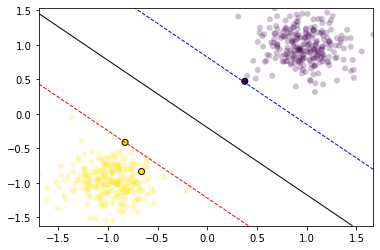

In [45]:
# Set model parameters and initial values
C = 10000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.005 # error tolerance
eps = 0.005 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error


output = train(model)

fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [ ]:
print(output.alphas)

In [38]:

# Add an outlier
X_outlier = np.append(X_train_scaled, [0.1, 0.1])
X_outlier = X_outlier.reshape(X_train.shape[0]+1, X_train.shape[1])
y_outlier = np.append(y, 1)

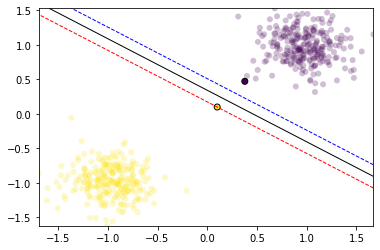

In [39]:
# Set model parameters and initial values
C = 10000.0
m = len(X_outlier)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

## What about regularization?
We can see above that a single outlier pushes the decision boundary much farther away from the rest of the population. We can eliminate this effect if we use a softer margin (a lower value for  $C$ ).



In [40]:
# Set model parameters and initial values
C = 1.0

initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

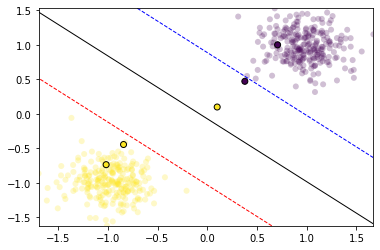

In [41]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)


Now the outlier won't influence our decision boundary as much.

